In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model  
from loss import custom_loss_wrapper
import os 
import h5py
import glob
from utils import convertXY2PtPhi


2025-07-14 16:11:14.844133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model_dir = '/home/users/dprimosc/L1METML/symmetric_loss_patience10/logs/'
model_name = 'model.h5'
model = load_model(model_dir + model_name, custom_objects={'custom_loss':custom_loss_wrapper})


In [4]:
# Pre-processing done in .h5 conversion
sample = 'MinBias'
tag = '25Jul8_140X_v0'
data_dir = f'/ceph/cms/store/user/dprimosc/l1deepmet_data/{tag}/{sample}_PU200/FP/140Xv0/'
#data_dir = f'/ceph/cms/store/user/dprimosc/l1deepmet_data/{tag}/'
h5_files = glob.glob(os.path.join(data_dir, f'*.h5'))

      

In [5]:
# Load and concatenate data from all files
X_data_list = []
Y_data_list = []

for h5_file in h5_files:
    print(f"Loading {os.path.basename(h5_file)}...")
    with h5py.File(h5_file, 'r') as f:
        # Check what datasets are available
        if len(X_data_list) == 0:  # Only print once
            print("Datasets in file:", list(f.keys()))
        
        # Load X and Y data
        X_batch = f['X'][:]  # Shape: (n_events, n_particles, n_features)
        Y_batch = f['Y'][:]  # Shape: (n_events, 2)
        
        X_data_list.append(X_batch)
        Y_data_list.append(Y_batch)
        print(f"  Loaded {X_batch.shape[0]} events")

# Concatenate all data
data = np.concatenate(X_data_list, axis=0)  # Shape: (total_events, n_particles, n_features)
Y = np.concatenate(Y_data_list, axis=0)     # Shape: (total_events, 2)

print(f"\nTotal concatenated data shape: {data.shape}")
print(f"Total target shape: {Y.shape}")
print(f"Total events: {data.shape[0]}")

Loading perfNano_12509504_154.h5...
Datasets in file: ['X', 'Y']
  Loaded 16319 events
Loading perfNano_12509504_119.h5...
  Loaded 2559 events
Loading perfNano_12509504_61.h5...
  Loaded 1759 events
Loading perfNano_12509504_71.h5...
  Loaded 16319 events
Loading perfNano_12509504_125.h5...
  Loaded 2559 events
Loading perfNano_12509504_85.h5...
  Loaded 16319 events
Loading perfNano_12509504_34.h5...
  Loaded 16319 events
Loading perfNano_12509504_43.h5...
  Loaded 16319 events
Loading perfNano_12509504_144.h5...
  Loaded 16319 events
Loading perfNano_12509504_66.h5...
  Loaded 2239 events
Loading perfNano_12509504_62.h5...
  Loaded 3199 events
Loading perfNano_12509504_129.h5...
  Loaded 1759 events
Loading perfNano_12509504_130.h5...
  Loaded 2079 events
Loading perfNano_12509504_63.h5...
  Loaded 3199 events
Loading perfNano_12509504_88.h5...
  Loaded 16319 events
Loading perfNano_12509504_23.h5...
  Loaded 16319 events
Loading perfNano_12509504_96.h5...
  Loaded 15039 events
Load

In [ ]:
# Assuming 'data' is loaded and has shape (batch_size, 128, >=8)
# Reconstruct X0-X3 from the 'data' array according to the encoding

# X0: pt, eta, phi, puppiW
X0 = data[:, :, [0, 3, 4, 5]]

# X1: px, py
X1 = data[:, :, [1, 2]]

# X2: encoded pdgId
X2 = data[:, :, 6].astype(int)

# X3: encoded charge
X3 = data[:, :, 7].astype(int)

In [6]:
# Ensure X2 and X3 indices are within the valid range for the embedding layer
#X2_clipped = np.clip(X2, 0, 3)
#X3_clipped = np.clip(X3, 0, 3)

# Run inference
prediction = model.predict([X0, X1, X2, X3])


9343/9343 [==============================] - 13s 1ms/step


In [116]:
# Calculate the magnitude (Euclidean norm) of each prediction vector
#prediction_magnitudes = np.linalg.norm(predictions, axis=1)
prediction_PtPhi = convertXY2PtPhi(prediction)
#target_magnitudes = np.linalg.norm(Y, axis=1)
target_PtPhi = convertXY2PtPhi(Y)


In [126]:
# Save predictions as the feature array
np.save(os.path.join(model_dir, f"{sample}_feature_array_MLMET.npy"), prediction)

# Save the target array Y 
np.save(os.path.join(model_dir, f"{sample}_target_array_MLMET.npy"), Y)


In [130]:
#TODO: check for correctness
# Compute PUPPI MET prediction using input features
# px = pt * cos(phi), py = pt * sin(phi), puppiw = X1[..., 1]
# X0[..., 1] = pt*cos(phi), X0[..., 2] = pt*sin(phi), X1[..., 1] = puppiw

# Sum over all particles for each event: MET_px = -sum(puppiw * px), MET_py = -sum(puppiw * py)
puppi_px = X1[..., 1] * X0[..., 1]
puppi_py = X1[..., 1] * X0[..., 2]
puppi_met_components = np.stack([
    -np.sum(puppi_px, axis=1),
    -np.sum(puppi_py, axis=1)
], axis=1)

# Calculate MET magnitude from px, py components
#puppi_met_magnitude = np.linalg.norm(puppi_met_components, axis=1)  # Shape: (n_events,)
puppi_met_PtPhi = convertXY2PtPhi(puppi_met_components)

# Calculate target MET magnitude
#target_met_magnitude = np.linalg.norm(Y, axis=1)  # Shape: (n_events,)

# Save PUPPI MET predictions as the feature array
np.save(os.path.join(model_dir, f"{sample}_feature_array_PUMET.npy"), puppi_met_components)

# Save the target array for PUPPI MET
np.save(os.path.join(model_dir, f"{sample}_target_array_PUMET.npy"), Y)

In [120]:
# Count number of events in TTbar and SingleNeutrino datasets
#ttbar_events = Tarray_PU.shape[0]
#singleneutrino_events = predictions.shape[0]

#print(f"Number of TTbar events: {ttbar_events}")
#print(f"Number of SingleNeutrino events: {singleneutrino_events}")

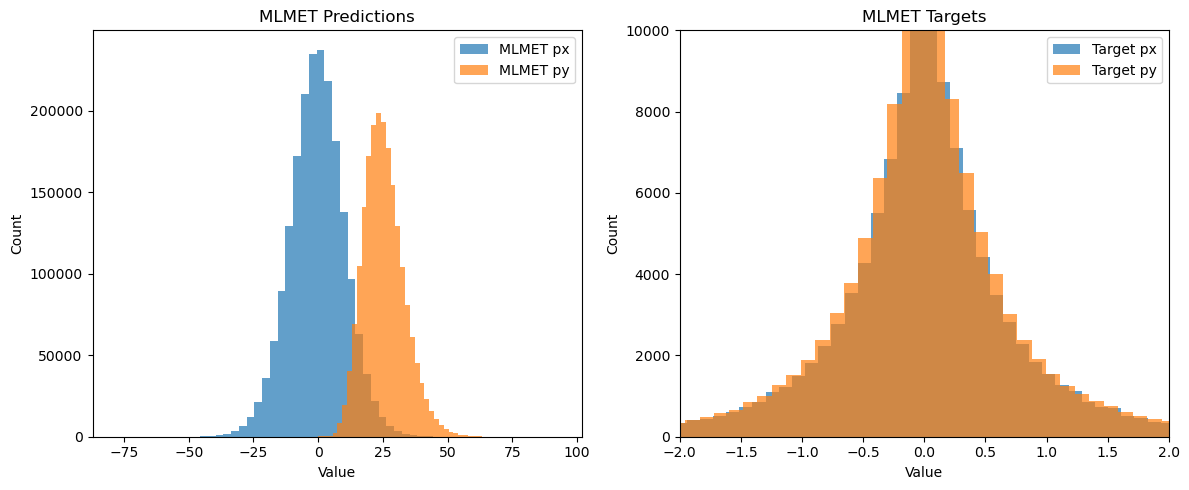

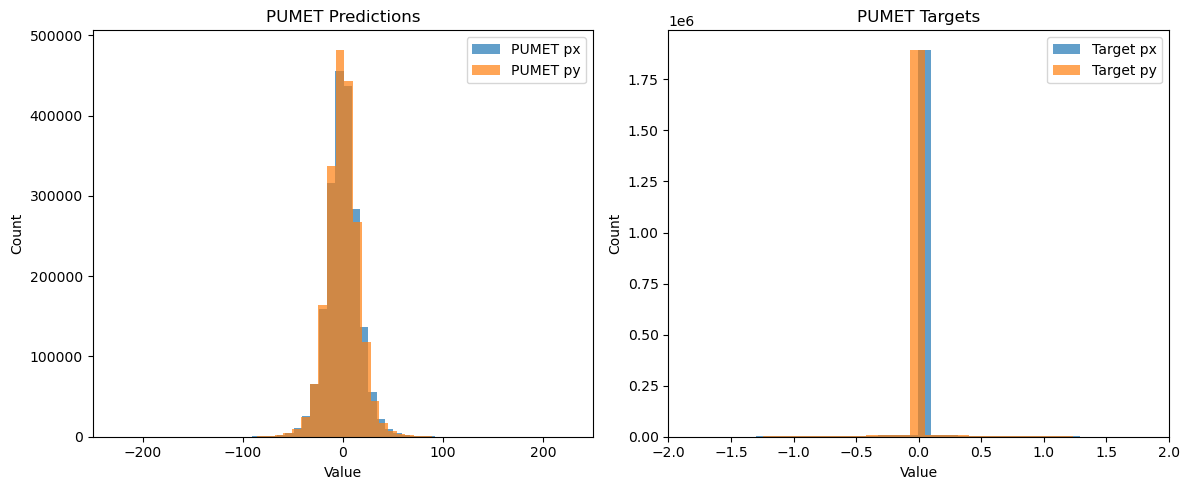

In [121]:
import matplotlib.pyplot as plt

# Plot histogram for predictions (MLMET feature array)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(prediction[:, 0], bins=50, alpha=0.7, label='MLMET px')
plt.hist(prediction[:, 1], bins=50, alpha=0.7, label='MLMET py')
plt.title('MLMET Predictions')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()

# Plot histogram for Y (MLMET target array)
plt.subplot(1, 2, 2)
plt.hist(Y[:, 0], bins=500, alpha=0.7, label='Target px')
plt.hist(Y[:, 1], bins=500, alpha=0.7, label='Target py')
plt.title('MLMET Targets')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xlim(-2,2)
plt.ylim(0,10000)
plt.legend()
plt.tight_layout()
plt.show()

# Plot histogram for puppi_met_pred (PUMET feature array)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(puppi_met_components[:, 0], bins=50, alpha=0.7, label='PUMET px')
plt.hist(puppi_met_components[:, 1], bins=50, alpha=0.7, label='PUMET py')
plt.title('PUMET Predictions')
plt.xlim(-250,250)
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()

# Plot histogram for Y (PUMET target array, same as above)
plt.subplot(1, 2, 2)
plt.hist(Y[:, 0], bins=500, alpha=0.7, label='Target px')
plt.hist(Y[:, 1], bins=500, alpha=0.7, label='Target py')
plt.title('PUMET Targets')
plt.xlabel('Value')
plt.xlim(-2,2)
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

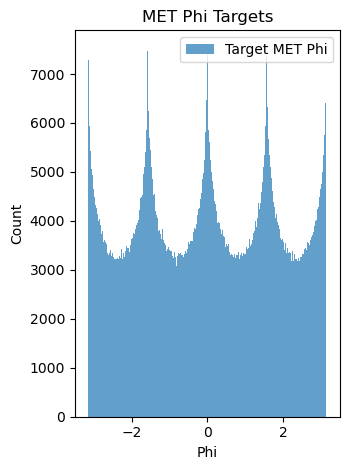

In [122]:
# Plot histogram for MET phi
plt.subplot(1, 2, 2)
plt.hist(convertXY2PtPhi(Y)[:,1], bins=500, alpha=0.7, label='Target MET Phi')
plt.title('MET Phi Targets')
plt.xlabel('Phi')
plt.ylabel('Count')
plt.xlim(-3.5,3.5)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:


# Create a new model with all layers after layer 13 removed

# Get the output of layer 13 (indexing starts from 0)
layer_w_out = model.get_layer('met_weight_minus_one').output

# Create a new model from the same inputs to the output of layer 13
model_w = Model(inputs=model.input, outputs=layer_w_out)

# Run inference using the new model
predictions_w = model_w.predict([X0, X1, X2, X3])


9343/9343 [==============================] - 13s 1ms/step


In [10]:
test = predictions_w.copy()
print(test[:,0].squeeze().shape)

(298975,)


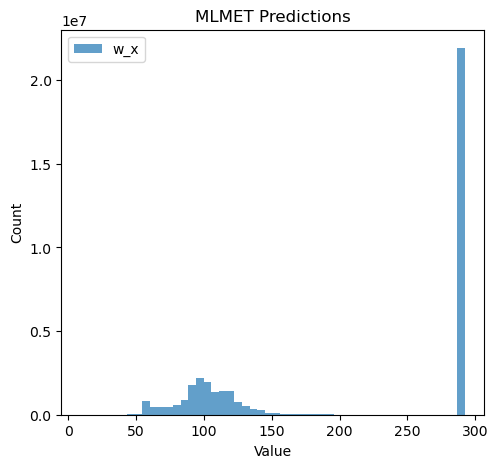

In [11]:
# Plot histogram for MET weights
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(predictions_w.flatten(), bins=50, alpha=0.7, label='w_x')
#plt.hist(predictions_w[:, 1], bins=50, alpha=0.7, label='w_y')
plt.title('MLMET Predictions')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()

In [13]:
# Flatten arrays for plotting
weights_flat = predictions_w.flatten()  # Layer 14 weights
px_flat = X0[..., 1].flatten()                 # px
py_flat = X0[..., 2].flatten()
print(weights_flat.shape)
print('---')
print(px_flat.shape)
print(py_flat.shape)


(38268800,)
---
(38268800,)
(38268800,)


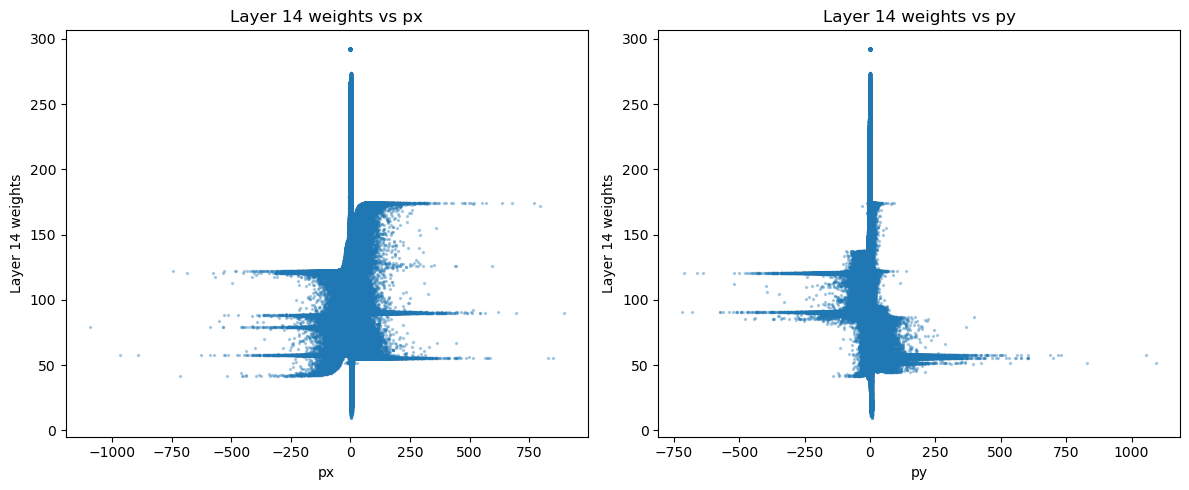

In [42]:
                  # py

plt.figure(figsize=(12, 5))

# Plot weights vs px
plt.subplot(1, 2, 1)
plt.scatter(px_flat, weights_flat, alpha=0.3, s=2)
plt.xlabel('px')
plt.ylabel('Layer 14 weights')
plt.title('Layer 14 weights vs px')

# Plot weights vs py
plt.subplot(1, 2, 2)
plt.scatter(py_flat, weights_flat, alpha=0.3, s=2)
plt.xlabel('py')
plt.ylabel('Layer 14 weights')
plt.title('Layer 14 weights vs py')

plt.tight_layout()
plt.show()


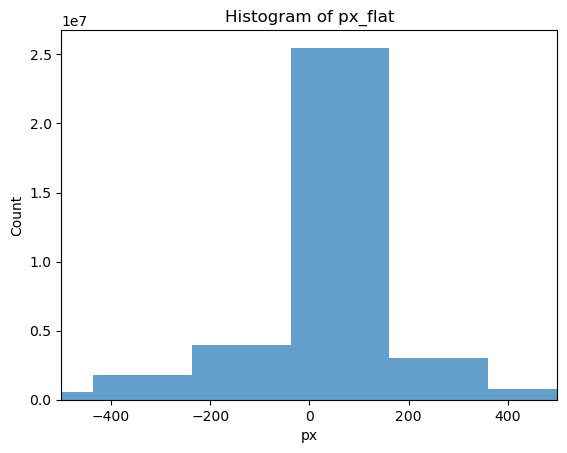

In [19]:
plt.hist(100*px_flat, bins=1000, alpha=0.7)
plt.title('Histogram of px_flat')
plt.xlabel('px')
plt.ylabel('Count')
plt.xlim(-500, 500)
plt.show()

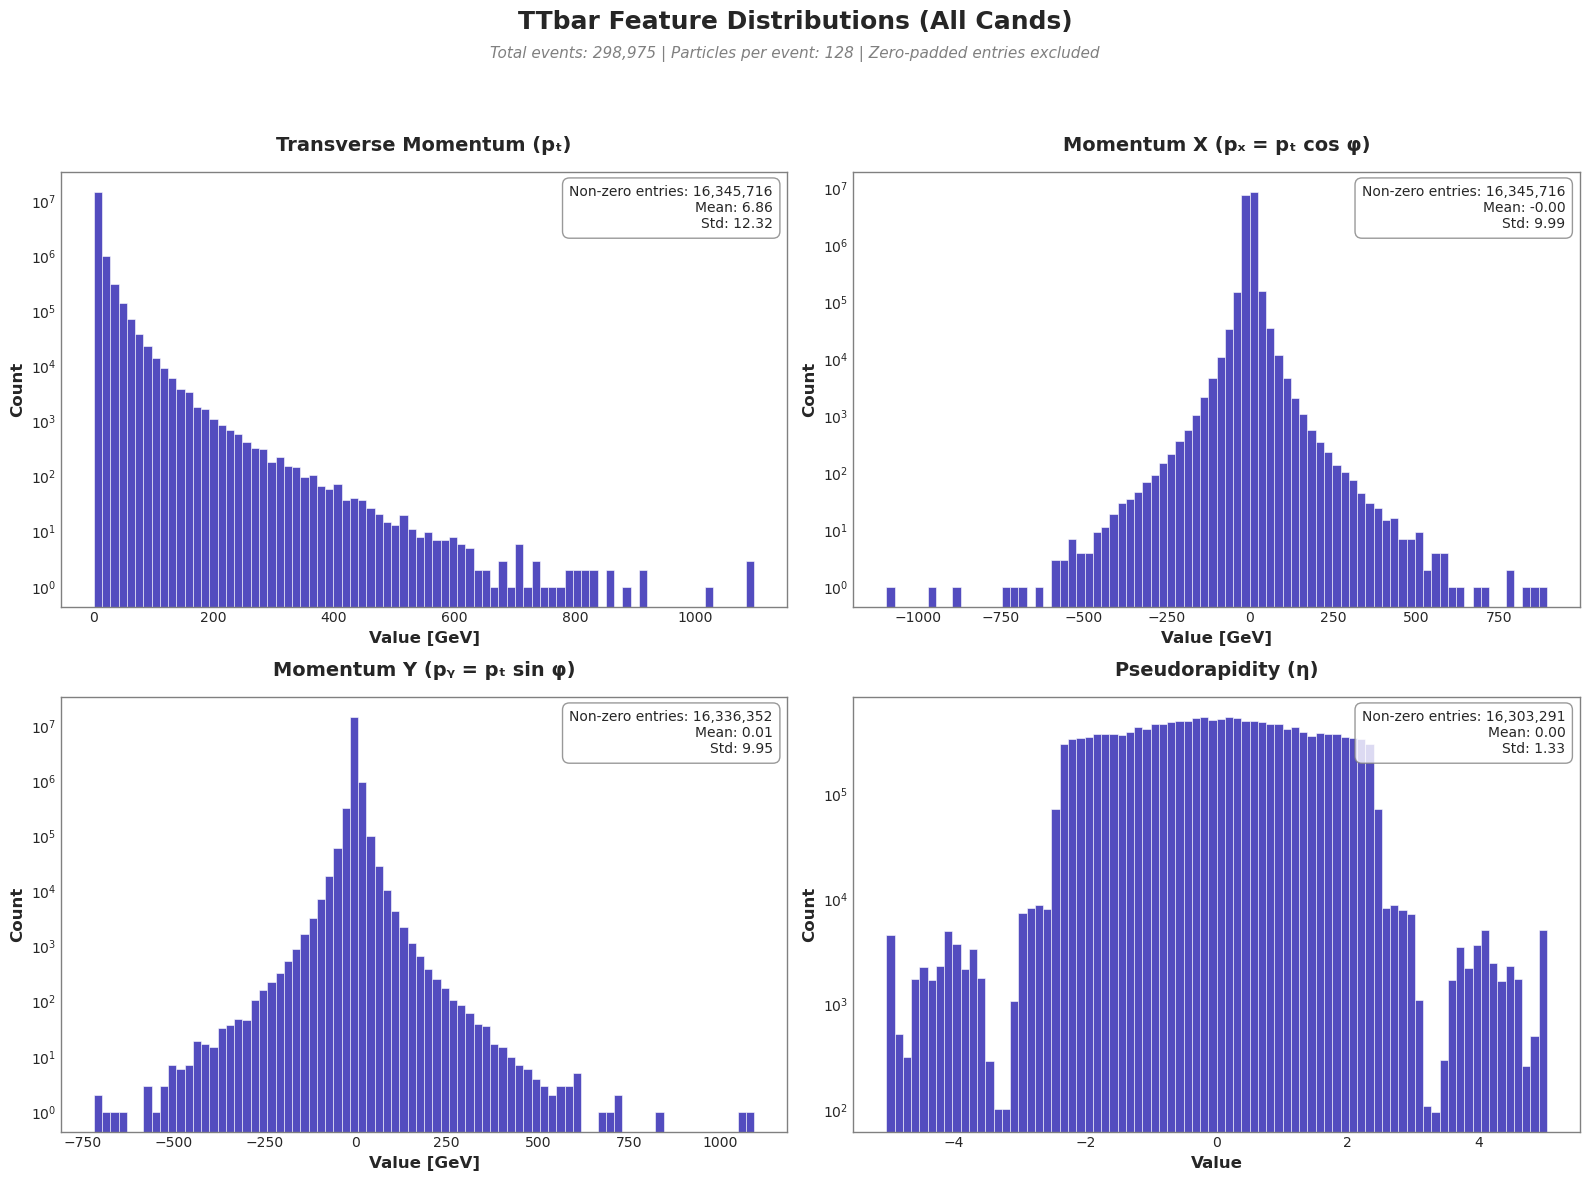

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Set modern plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# X0 has shape (n_events, n_particles, 4), features: [pt, pt*cos(phi), pt*sin(phi), eta]
feature_names = ['Transverse Momentum (pₜ)', 'Momentum X (pₓ = pₜ cos φ)', 'Momentum Y (pᵧ = pₜ sin φ)', 'Pseudorapidity (η)']
feature_units = ['GeV', 'GeV', 'GeV', '']
colors = ["#281FAF", "#281FAF", "#281FAF", "#281FAF"]  # Modern color palette

n_features = X0.shape[2]
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()  # Make indexing easier

for i in range(n_features):
    # Remove zeros and get clean data
    data_clean = X0[..., i].flatten()
    data_no_zeros = data_clean[data_clean != 0]
    
    # Create histogram with improved styling
    n, bins, patches = axs[i].hist(data_no_zeros, bins=80, alpha=0.8, 
                                   color=colors[i], edgecolor='white', linewidth=0.5)
    
    # Add gradient effect to bars
    #for j, patch in enumerate(patches):
    #    patch.set_facecolor(plt.cm.viridis(j / len(patches)))
    
    # Styling improvements
    axs[i].set_title(f'{feature_names[i]}', fontsize=14, fontweight='bold', pad=15)
    axs[i].set_xlabel(f'Value [{feature_units[i]}]' if feature_units[i] else 'Value', 
                      fontsize=12, fontweight='semibold')
    axs[i].set_ylabel('Count', fontsize=12, fontweight='semibold')
    axs[i].set_yscale('log')
    
    # Add statistics text box
    stats_text = f'Non-zero entries: {len(data_no_zeros):,}\n'
    stats_text += f'Mean: {np.mean(data_no_zeros):.2f}\n'
    stats_text += f'Std: {np.std(data_no_zeros):.2f}'
    
    axs[i].text(0.98, 0.97, stats_text, transform=axs[i].transAxes, 
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Improve grid
    axs[i].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    axs[i].set_axisbelow(True)
    
    # Add subtle border
    for spine in axs[i].spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(1)

# Overall title and layout
fig.suptitle('TTbar Feature Distributions (All Cands)', 
             fontsize=18, fontweight='bold', y=0.98)

# Add subtitle with dataset info
fig.text(0.5, 0.94, f'Total events: {X0.shape[0]:,} | Particles per event: {X0.shape[1]} | Zero-padded entries excluded', 
         ha='center', fontsize=11, style='italic', color='gray')

plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space for title
plt.show()

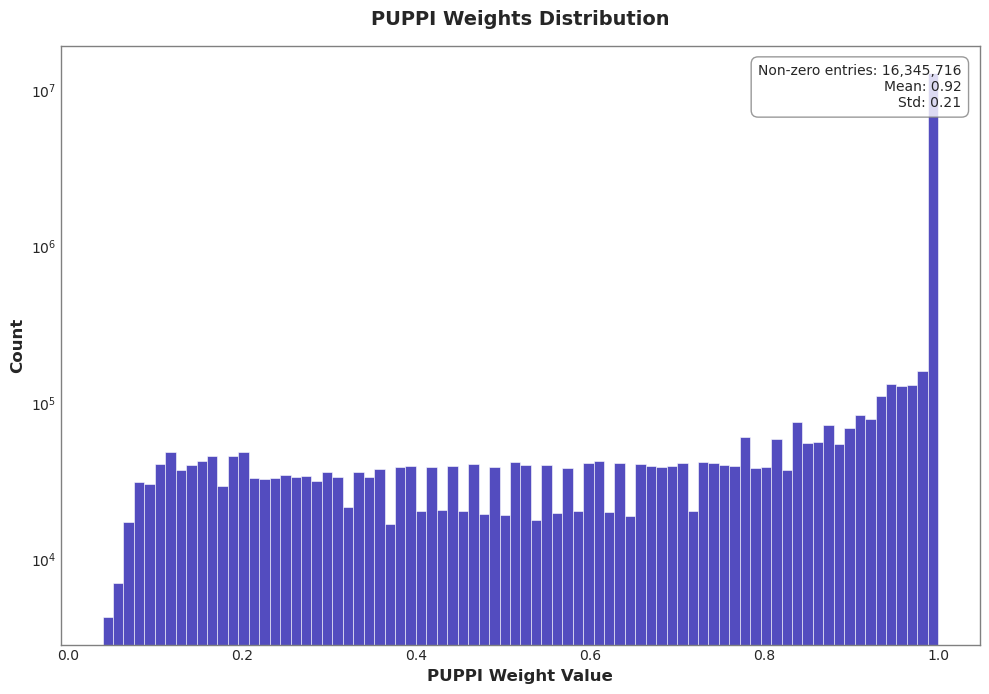

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Set modern plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Plot PUPPI weights distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Remove zeros and get clean data for PUPPI weights
data_clean = X1[..., 1].flatten()  # PUPPI weights from X1[:, :, 1]
data_no_zeros = data_clean[data_clean != 0]

# Create histogram with improved styling
n, bins, patches = ax.hist(data_no_zeros, bins=80, alpha=0.8, 
                           color='#281FAF', edgecolor='white', linewidth=0.5)

# Styling improvements
ax.set_title('PUPPI Weights Distribution', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('PUPPI Weight Value', fontsize=12, fontweight='semibold')
ax.set_ylabel('Count', fontsize=12, fontweight='semibold')
ax.set_yscale('log')

# Add statistics text box
stats_text = f'Non-zero entries: {len(data_no_zeros):,}\n'
stats_text += f'Mean: {np.mean(data_no_zeros):.2f}\n'
stats_text += f'Std: {np.std(data_no_zeros):.2f}'

ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray'))

# Improve grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Add subtle border
for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

plt.tight_layout(rect=[0, 0, 1, 0.88])  # Leave space for subtitle
plt.show()